In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import piecewise_regression

from utils.optimal_price_utils import *


> **Intro:** In this notebook, we try to identify the price that maximizes revenue for a fashion item using survey data.<br><br> 
**Data collection:** The data was obtained from a survey of a group of approximately 2800 people, where the group was presented with different price levels, and then got willingness to buy the product.
<br><br>
**Methodology:** Using machine learning and statistical aproaches to model the relationship between price and demand.
   

> # Creating the Dataset

In [ ]:
# read the dataset
data = pd.read_csv('./datasets/prices.csv')

In [3]:
# sort data by price
data.sort_values(by="price", inplace=True, ignore_index=True)

In [4]:
data

,price,demand
0,10,2800
1,20,2000
2,40,1200
3,60,300
4,70,200
5,90,120
6,100,100


In [5]:
# create revenue column, revenue = price * demand
data["revenue"] = data["price"] * data["demand"]

In [6]:
data

,price,demand,revenue
0,10,2800,28000
1,20,2000,40000
2,40,1200,48000
3,60,300,18000
4,70,200,14000
5,90,120,10800
6,100,100,10000


> # EDA

In [7]:
# get number of samples
data.shape[0]

7

In [8]:
# get number of unique prices
len(data.price.unique())

7

<div class="alert alert-block alert-success"><strong>
we have 7 different prices (7 samples)

In [9]:
# get max demand
data.demand.max()

2800

<div class="alert alert-block alert-success"><strong>
the data is collected from approximately 2800 people

In [10]:
# get simple statistics
data.describe()

,price,demand,revenue
count,7.000000,7.000000,7.000000
mean,55.714286,960.000000,24114.285714
std,34.086724,1078.826523,15023.029940
min,10.000000,100.000000,10000.000000
25%,30.000000,160.000000,12400.000000
50%,60.000000,300.000000,18000.000000
75%,80.000000,1600.000000,34000.000000
max,100.000000,2800.000000,48000.000000


<div class="alert alert-block alert-success"><strong>
- price: mean prices is 55, minimum price is 10, and maximum is 100, distribution seems normal (mean and median are almost the same)
 <br> <br>
- demand: minimum demand is 160 and maximum is 2800, distributin seems right skewed (the mean is very high comparing to median, the mean is shifted to the right because the presence of high values)

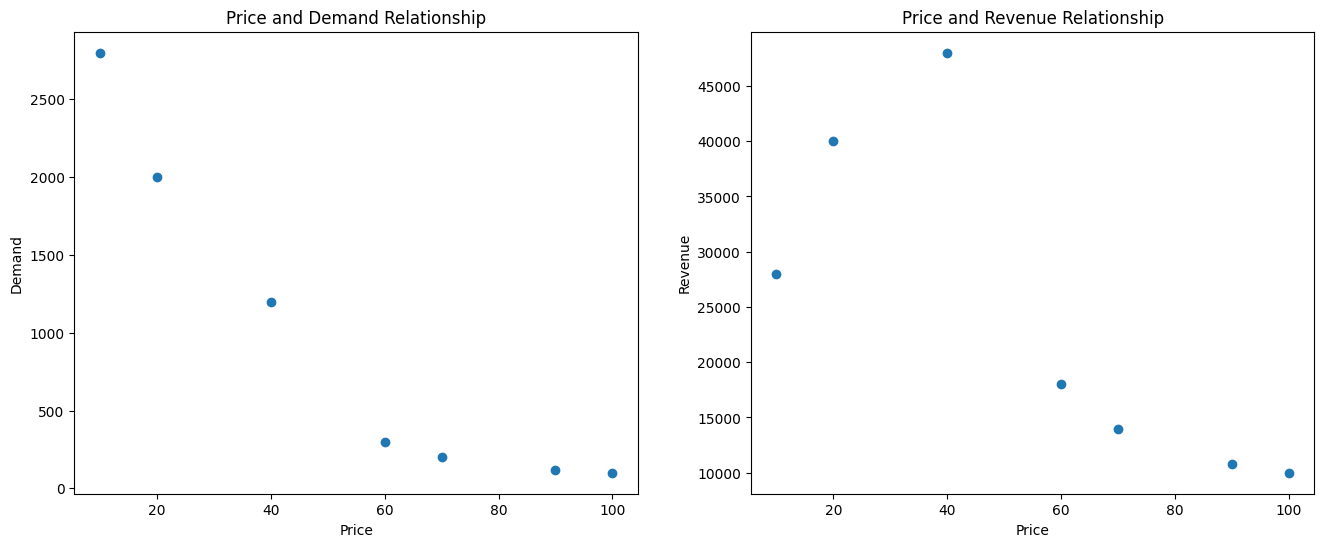

In [11]:
# scatter plot for price and demand
plot_price_data(data)

<div class="alert alert-block alert-success"><strong>
     - We can see from the left scatter plot above that the demand is decreasing extremely until reaching a certain price (50-60) then the demand continue to decrease with a small percentage. <br><br>
    - We can assume that the demand elasticity (how much the demand is sensitive to price changes) is not constant, from 0 to 60 demand is elastic (demand is sensitive to price changes, the changes in price leads to big changes on the demand), on the other hand, if you look at range 60 - 100 demand is inelastic (demand is changing slightly when price changes). That means the demand elasticity changes after the price 50-60 (demand becomes less sensitive to price changes after that ponit).<br><br>
    - So this jump in the demand could be related to a price threshold, were people have a pre-knowledge about the product price that they only buy with same price or less. Or price anchoring, given the survey is done on the same group of people that were presented by different prices, so maybe data is baised somehow. but still all of these are just assumptions.<br><br>
    - The right plot shows that the revenue is increasing until a certian price and then drops extremely. So our goal is to find the price at which the reveue drops after it.
 </div>
   

> # Optimal Price

## Base Model

<div class="alert alert-block alert-info">
    In our base model we would like to follow the nature of the proplem, price/demand behavoiur usually follow an exponentially decreasing relationship aka exponential decay model. So we will fit a exponential decay model to our price/demand data.
 </div>
   

> exponential decay model equation:
$$ demand(price) = a \cdot e^{-b \cdot price} $$
a: demand when price is 0.<br>
e: natural logarithm constant.<br>
b: decay rate.<br>

In [12]:
# fit the model to our data
params, _ = curve_fit(exponential_decay_model, data["price"], data["demand"])

/opt/homebrew/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
params

array([4.07916530e+03, 3.60280378e-02])

In [14]:
# generate 1000 prices from our min price to max one
generated_prices = np.linspace(min(data["price"]), max(data["price"]), 1000)

In [15]:
# use the params got the fit, apply the exp equation on the generated prices
predicted_demands_using_exp_model = exponential_decay_model(generated_prices, *params)

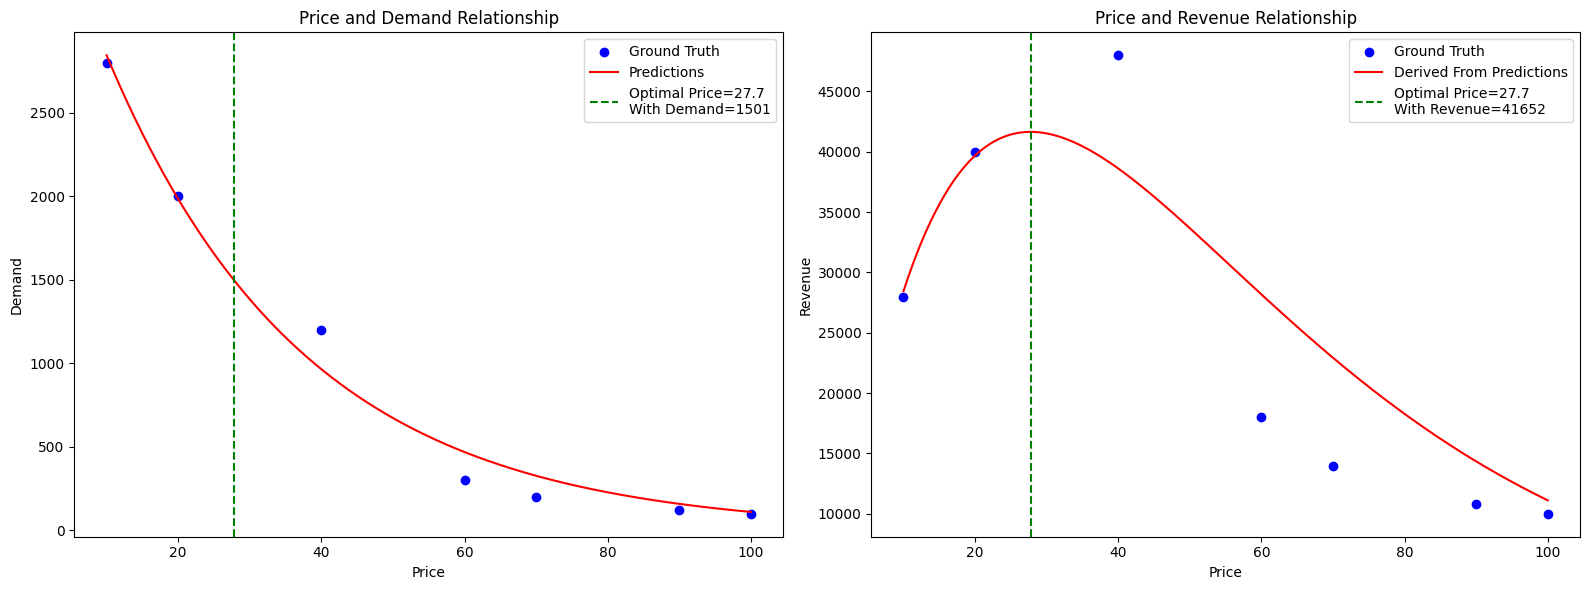

In [16]:
# plot the results
plot_predictions(
    data,
    generated_prices,
    predicted_demands_using_exp_model,
    predicted_demands_using_exp_model * generated_prices,
)

<div class="alert alert-block alert-success"><strong>
    - The optimal price using this model is 27.7 with demand of 1501 and revenue of 41652<br><br>
     - The left plot shows predicted demands for the entire rage of prices, it seems the curve didn't fit well our data. A small error in the demand prediction could lead to a high error in the revenue, because the calculations include multiplication, if you look at the price 40, the model didin't fit it well and that leads high error in the revenue leading to miss the optimal price.<br><br>
    - Given that our model didn't fit the data well could be related to the idea of changing elasticity, this extreme change in the price/demand behaviour could suggest using another approach to capture this extreme elasticity change.
 </div>
   

##  Piecewise Regression

<div class="alert alert-block alert-info">
    In this model we will try to model each part of the price/demand behaviour separately, you can imagine as two linear regressions fit each part (elasticity and inelastic), the threshold between two parts will be automaticly detected using the best fit of the model.
 </div>
   

In [17]:
# fit piecewise regression model using 1 breakpoint as we have just two parts
piecewise_fit = piecewise_regression.Fit(
    np.array(data["price"]), np.array(data["demand"]), n_breakpoints=1
)

In [18]:
# get the model summary to get the two linear model parameters
piecewise_fit.summary()


                    Breakpoint Regression Results                     
No. Observations                        7
No. Model Parameters                    4
Degrees of Freedom                      3
Res. Sum of Squares               47474.3
Total Sum of Squares           6.9832e+06
R Squared                        0.993202
Adjusted R Squared               0.979605
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                 3200.0     1.54e+02        20.77      0.000244       2709.7       3690.3
alpha1              -51.4286         5.82      -8.8316       0.00306      -69.961      -32.896
beta1                46.6286         7.05       6.6118             -       24.185       69.072
breakpoint1          56.5319         5.04            -             -       40.479       72.585
-----------------

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                        7\nNo. Model Parameters                    4\nDegrees of Freedom                      3\nRes. Sum of Squares               47474.3\nTotal Sum of Squares           6.9832e+06\nR Squared                        0.993202\nAdjusted R Squared               0.979605\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst                 3200.0     1.54e+02        20.77      0.000244       270

<div class="alert alert-block alert-success">
    We can see that const (3200), alpha1 (-51.4286), alpha2 (-4.8) and the price threshold (56.5319).<br><br>
    - The first linear equation for values <= 56.5319: <br>
    <strong>demand = 3200 - 51.4286 * price</strong><br><br>
     - The second linear equation for values > 56.5319: <br>
    <strong>demand_at_threshold = 3200 - 51.4286 * 56.5319<br>  
    demand = demand_at_threshold - 4.8 * (price - 56.5319)</strong>
 </div>
   

In [19]:
# define the model params
const = 3200.0
alpha1 = -51.4286
alpha2 = -4.8
breakpoint1 = 56.5319

In [20]:
# predict demands
predicted_demands_using_piecewise_model = [
    predict_piecewise(price, const, alpha1, alpha2, breakpoint1)
    for price in generated_prices
]

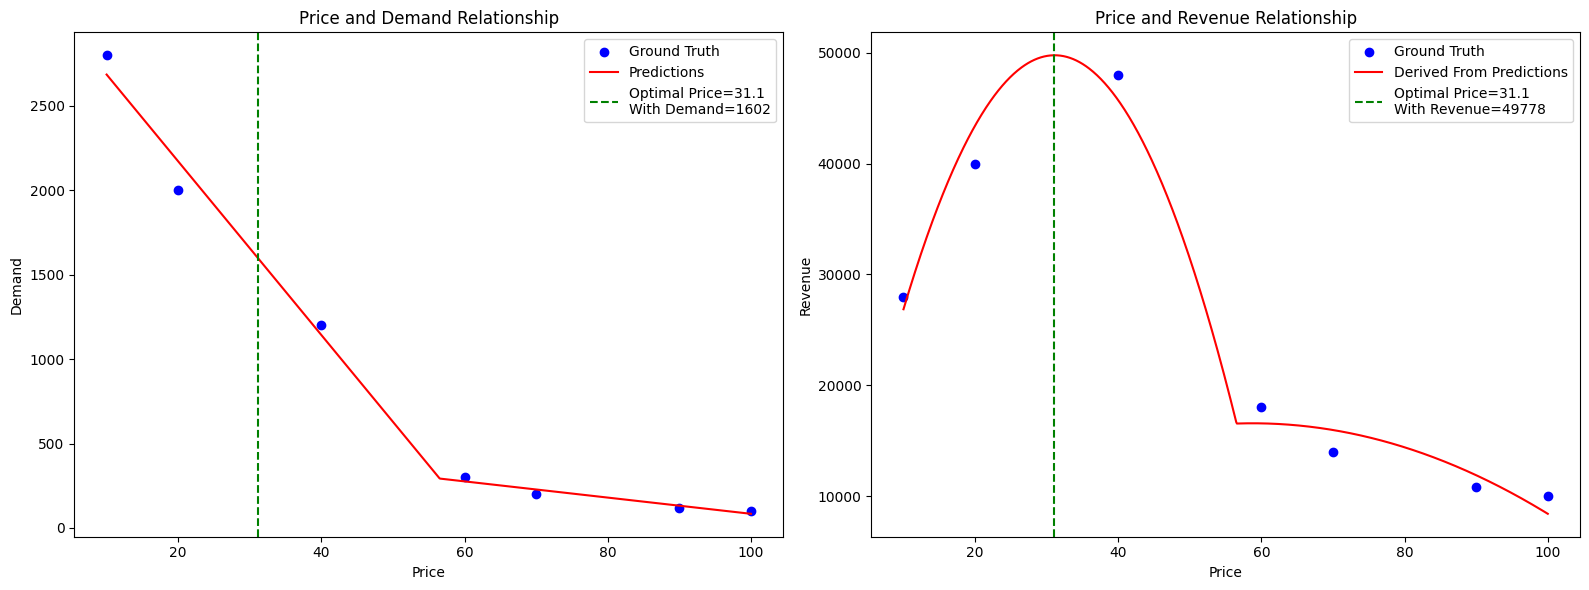

In [21]:
# plot the results
plot_predictions(
    data,
    generated_prices,
    predicted_demands_using_piecewise_model,
    predicted_demands_using_piecewise_model * generated_prices,
)

<div class="alert alert-block alert-success"> <strong>
- Using this model the optimal price is 31.1 with demand of 1602 and reveue of 49778<br><br>
   - We can see the new model fited the two part separately with a threshold of 56.5319, and also was able to capture the revenue in a good way.</strong>
 </div>
   

<div class="alert alert-block alert-success"> <strong>
As a conclusion the optimal price is 31.1, with demand of 1602 and reveue of 49778 </strong>
 </div>
   